In [17]:
# Baseline: Logistic Regression (SGD-style workflow) for 3-class price movement
# Dataset: master_dataset_ml_ready_labelled.csv
# Target: price_movement_scaled in {-1, 0, 1}

# --- 0) Imports ---
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix


# --- 1) Load data ---
DATA_PATH = "/content/master_dataset_ml_ready_labelled.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print(df.head(3))

Shape: (5202, 21)
                  date  CDD_TX  CDD_PA  CDD_IL  CDD_NY  HDD_TX  HDD_PA  \
0  2010-01-01 00:00:00       0       0       0       0      22      33   
1  2010-01-02 00:00:00       0       0       0       0      24      43   
2  2010-01-03 00:00:00       0       0       0       0      24      48   

   HDD_IL  HDD_NY  contract_1_price  ...  spot_price  storage_bcf  \
0      56      33              5.88  ...        6.09         3117   
1      61      39              5.88  ...        6.09         3117   
2      60      49              5.88  ...        6.09         3117   

   us_gas_rigs  year  month  day_of_year  day_of_week  quarter  \
0          759  2010      1            1            4        1   
1          759  2010      1            2            5        1   
2          759  2010      1            3            6        1   

   price_movement_raw  price_movement_scaled  
0                 0.0                      0  
1                 0.0                      0  
2 

Delta-like columns found: []


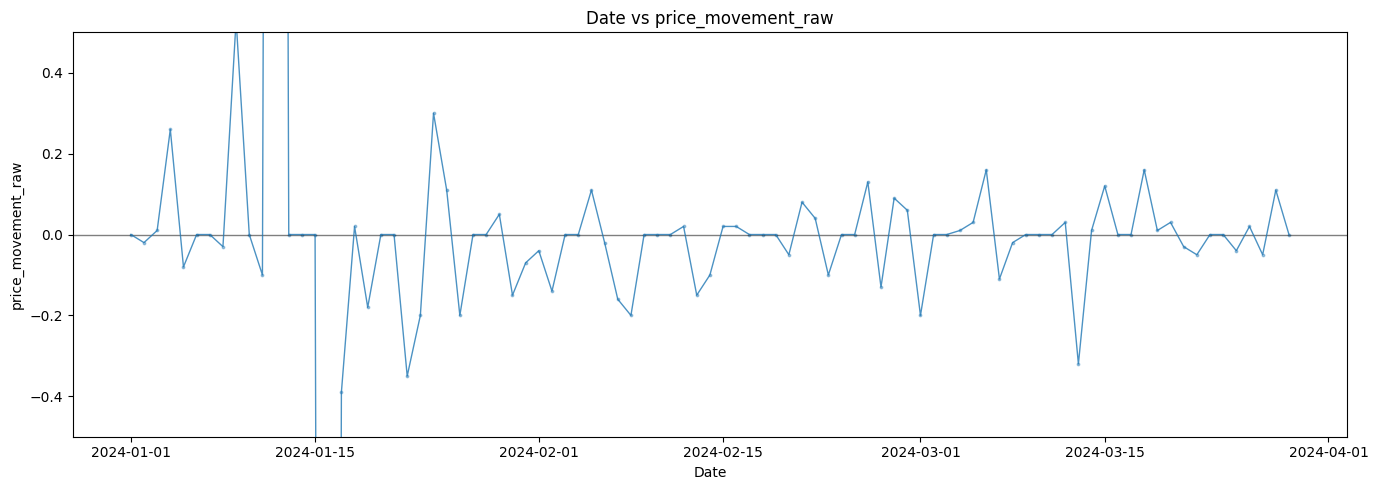

In [18]:
#plotting values
import matplotlib.pyplot as plt

# Make sure date is datetime
df_plot = df.copy()
df_plot["date"] = pd.to_datetime(df_plot["date"], errors="coerce")

# Try to find a raw delta-like column automatically
candidates = [c for c in df_plot.columns if any(tok in c.lower() for tok in ["delta", "diff", "change", "return"])]
print("Delta-like columns found:", candidates)

# Pick the first one if it exists, else fall back to scaled target
if candidates:
    ycol = candidates[0]
    title = f"Date vs {ycol} (raw movement)"
else:
    ycol = "price_movement_raw"
    title = "Date vs price_movement_raw"

# Drop rows with missing values for clean plotting
plot_df = df_plot[["date", ycol]].dropna().sort_values("date")
plot_df = plot_df[(plot_df["date"] >= "2024-01-01") & (plot_df["date"] <= "2024-12-31")]

plt.figure(figsize=(14, 5))
plt.scatter(plot_df["date"], plot_df[ycol], s=3, alpha=0.4)
plt.axhline(0, color="black", linewidth=1, alpha=0.5)
plt.title(title)
plt.xlabel("Date")
plt.ylabel(ycol)
plt.tight_layout()
plt.plot(plot_df["date"], plot_df[ycol], linewidth=1, alpha=0.8)

plt.ylim(-0.5, 0.5)


plt.show()


In [19]:
# --- 2) Basic sanity checks ---
TARGET_COL = "price_movement_scaled"
DATE_COL = "date"  # per your description

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available columns: {list(df.columns)[:20]}...")

# Print target distribution
print("\nTarget distribution:")
print(df[TARGET_COL].value_counts(dropna=False).sort_index())

# Peek at dtypes
print("\nDtypes (first 25):")
print(df.dtypes.head(25))



Target distribution:
price_movement_scaled
-1    1595
 0    2046
 1    1561
Name: count, dtype: int64

Dtypes (first 25):
date                      object
CDD_TX                     int64
CDD_PA                     int64
CDD_IL                     int64
CDD_NY                     int64
HDD_TX                     int64
HDD_PA                     int64
HDD_IL                     int64
HDD_NY                     int64
contract_1_price         float64
contract_2_price         float64
spot_price               float64
storage_bcf                int64
us_gas_rigs                int64
year                       int64
month                      int64
day_of_year                int64
day_of_week                int64
quarter                    int64
price_movement_raw       float64
price_movement_scaled      int64
dtype: object


In [20]:
# --- 3) Define features (drop date for baseline) ---
# For the first pass, we drop the date index-like column.
# We'll also drop the target from X.
drop_cols = [TARGET_COL, "price_movement_raw"]
if DATE_COL in df.columns:
    drop_cols.append(DATE_COL)

X = df.drop(columns=drop_cols)
y = df[TARGET_COL]

# If y was read as float because of NaNs, coerce to int where possible.
# Keep NaNs so we can drop them cleanly.
y = pd.to_numeric(y, errors="coerce")

# Drop rows with missing target
mask = y.notna()
X = X.loc[mask].copy()
y = y.loc[mask].astype(int)

# Confirm allowed labels
allowed = {-1, 0, 1}
labels_present = set(np.unique(y))
if not labels_present.issubset(allowed):
    raise ValueError(f"Unexpected labels in y: {sorted(labels_present)}. Expected subset of {sorted(allowed)}")

print("\nAfter dropping missing target:")
print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts().sort_index())


After dropping missing target:
X shape: (5202, 18)
y distribution:
price_movement_scaled
-1    1595
 0    2046
 1    1561
Name: count, dtype: int64


In [21]:
# --- 4) Train/test split ---
# Stratify to preserve class proportions.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nSplit sizes:")
print("Train:", X_train.shape, "Test:", X_test.shape)


Split sizes:
Train: (4161, 18) Test: (1041, 18)


In [22]:
# --- 5) Build preprocessing + model pipeline ---
# This baseline assumes features are numeric. We'll:
# - impute missing values with median
# - standardize
# - fit multinomial logistic regression

# Identify numeric columns
numeric_cols = X_train.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]),
            numeric_cols,
        )
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# Multiclass logistic regression.
# 'saga' works well with many features and supports multinomial.
# Increase max_iter if you see ConvergenceWarning.
clf = LogisticRegression(
    multi_class="multinomial",
    solver="saga",
    max_iter=5000,
    n_jobs=None,
    class_weight=None,  # consider 'balanced' if classes are very skewed
    random_state=42,
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", clf),
])

In [23]:
# --- 6) Baseline: Dummy classifier ---
# Always predicts most frequent class
baseline = DummyClassifier(strategy="most_frequent", random_state=42)
baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_test)

print("\n=== Dummy baseline ===")
print("Accuracy:", accuracy_score(y_test, base_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, base_pred))


=== Dummy baseline ===
Accuracy: 0.39385206532180594
Balanced accuracy: 0.3333333333333333


In [24]:
# --- 7) Train model ---
pipe.fit(X_train, y_train)


# --- 8) Evaluate ---
y_pred = pipe.predict(X_test)

print("\n=== Logistic Regression baseline ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred, labels=[-1, 0, 1]))
print("\nClassification report:")
print(classification_report(y_test, y_pred, labels=[-1, 0, 1]))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression baseline ===
Accuracy: 0.5629202689721422
Balanced accuracy: 0.5399658093518481

Confusion matrix (rows=true, cols=pred):
[[ 89 103 127]
 [ 30 329  51]
 [ 75  69 168]]

Classification report:
              precision    recall  f1-score   support

          -1       0.46      0.28      0.35       319
           0       0.66      0.80      0.72       410
           1       0.49      0.54      0.51       312

    accuracy                           0.56      1041
   macro avg       0.53      0.54      0.53      1041
weighted avg       0.54      0.56      0.54      1041



In [25]:
#okay now we'll do the SGD, referencing the thing...after we have a little snack blondie
from sklearn.linear_model import SGDClassifier #import the classifier
#we can reuse our x_train and so on from log regress
SGD_model = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) # tol: the stopping criterion, this is ripped from our lab notebook
SGD_model.fit(X_train, y_train)
SGD_predictions = SGD_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, SGD_predictions))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,SGD_predictions))


Accuracy: 0.2987512007684918
[[  0   0 319]
 [  0   0 410]
 [  1   0 311]]


In [26]:
#sorry, did this thing fucking get 0 of the -1 and 1s right? did it even predict?
np.unique(SGD_predictions, return_counts=True)
X_train.isna().any().any()

np.False_

In [27]:
#try again with feature scaling
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pipe2 = Pipeline([
    ("scaler", StandardScaler()),
    ("SGD", SGDClassifier(max_iter=1000, tol=1e-3, random_state=42, loss="log_loss")),
])
pipe2.fit(X_train, y_train)
sgd_pred = pipe2.predict(X_test)
print("\n=== SGD naive results ===")
print("Accuracy:", accuracy_score(y_test, sgd_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, sgd_pred))
print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, sgd_pred, labels=[-1, 0, 1]))
print("\nClassification report:")
print(classification_report(y_test, sgd_pred, labels=[-1, 0, 1]))


=== SGD naive results ===
Accuracy: 0.5494716618635928
Balanced accuracy: 0.5258792884528797

Confusion matrix (rows=true, cols=pred):
[[139  86  94]
 [ 56 321  33]
 [140  60 112]]

Classification report:
              precision    recall  f1-score   support

          -1       0.41      0.44      0.43       319
           0       0.69      0.78      0.73       410
           1       0.47      0.36      0.41       312

    accuracy                           0.55      1041
   macro avg       0.52      0.53      0.52      1041
weighted avg       0.54      0.55      0.54      1041



In [28]:
from auto_feature_selector2 import AutoFeatureSelector
pipe3 = Pipeline([
    ("scaler", StandardScaler()),
    ("select", AutoFeatureSelector(methods=("mutual_info","anova_f","l1_logreg","rf_gini"),
                                   top_k=10, vote_threshold=3, verbose=False)),
    ("clf", SGDClassifier(loss="log_loss", max_iter=2000, tol=1e-3, random_state=42)),
])
pipe3.fit(X_train, y_train)
sgd_pred2 = pipe3.predict(X_test)
print("\n=== SGD naive results ===")
print("Accuracy:", accuracy_score(y_test, sgd_pred2))
print("Balanced accuracy:", balanced_accuracy_score(y_test, sgd_pred2))
print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, sgd_pred2, labels=[-1, 0, 1]))
print("\nClassification report:")
print(classification_report(y_test, sgd_pred2, labels=[-1, 0, 1]))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== SGD naive results ===
Accuracy: 0.5552353506243997
Balanced accuracy: 0.5323180207326549

Confusion matrix (rows=true, cols=pred):
[[116  92 111]
 [ 43 323  44]
 [109  64 139]]

Classification report:
              precision    recall  f1-score   support

          -1       0.43      0.36      0.40       319
           0       0.67      0.79      0.73       410
           1       0.47      0.45      0.46       312

    accuracy                           0.56      1041
   macro avg       0.53      0.53      0.53      1041
weighted avg       0.54      0.56      0.54      1041



In [29]:
#we do a little gridsearching
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    # Regularization strength (main lever). Smaller alpha = less regularization.
    "clf__alpha": [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3],

    # Penalty type
    "clf__penalty": ["l2", "l1", "elasticnet"],

    # Only used for elasticnet; ignored otherwise
    "clf__l1_ratio": [0.15, 0.5, 0.85],

    # Learning rate policy
    "clf__learning_rate": ["optimal", "adaptive"],

    # Max iters / tolerance (optional; can help convergence)
    "clf__max_iter": [2000, 5000],
    "clf__tol": [1e-3, 1e-4],

    # If you want to be extra safe on class balance, include balanced:
    # (since you said fairly even, this may not matter much)
    "clf__class_weight": [None, "balanced"],
}

param_grid_small = {
    "clf__loss": ["log_loss"],
    "clf__alpha": [1e-5, 3e-5, 1e-4, 3e-4, 1e-3],
    "clf__penalty": ["l2", "l1"],
    "clf__learning_rate": ["optimal", "adaptive"],
    "clf__class_weight": [None, "balanced"],
}

pipe_sgd = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", SGDClassifier(
        loss="log_loss",
        random_state=42,
        eta0=0.01,          # <- add this
        max_iter=2000,
        tol=1e-3
    ))
])


# Scoring: balanced_accuracy is usually better for 3-class movement
grid = GridSearchCV(
    estimator=pipe_sgd,
    param_grid=param_grid_small,
    scoring="balanced_accuracy",
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    refit=True,
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['CDD_TX',
                                                                          'CDD_PA',
                                                                          'CDD_IL',
                                                                          'CDD_NY',
                                                                          'HDD_TX',
                                                                          'HDD_PA',
                                                                          'HDD_IL',
                                                                          'HDD_NY',
                                                                          'contract_1_price',
                                                                          'co...
                                                          verbose_feature_names_out=False)),
                                       ('clf',
                                        SGDClassifier(eta0=0.01,
                                                      loss='log_loss',
                                                      max_iter=2000,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [1e-05, 3e-05, 0.0001, 0.0003, 0.001],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__learning_rate': ['optimal', 'adaptive'],
                         'clf__loss': ['log_loss'],
                         'clf__penalty': ['l2', 'l1']},
             scoring='balanced_accuracy', verbose=2)

In [30]:
print("\nBest CV score (balanced acc):", grid.best_score_)
print("Best params:\n", grid.best_params_)



Best CV score (balanced acc): 0.5539747884745507
Best params:
 {'clf__alpha': 0.001, 'clf__class_weight': 'balanced', 'clf__learning_rate': 'optimal', 'clf__loss': 'log_loss', 'clf__penalty': 'l1'}
